In [33]:
import folktables
from folktables import ACSDataSource, ACSIncome, ACSEmployment

import numpy as np

## Data Loading

In [34]:
def post_2018_relp_mapping(df):
    relp_mapping = {
        20: 0,
        21: 1, # distinction between same-sex and opposite-sex partnerships
        22: 13, # distinction between same-sex and opposite-sex partnerships
        23: 1,
        24: 13,
        25: 2,
        26: 3,
        27: 4,
        28: 5,
        29: 6,
        30: 7,
        31: 8,
        32: 9,
        33: 10,
        34: 12, # roomer or boarder category disappeared
        35: 14,
        36: 15,
        37: 16,
        38: 17
    }

    assert 'RELSHIPP' in df.columns, "Must only be used for post-2018 data with modified RELSHIPP column."

    df['RELP'] = df['RELSHIPP'].map(relp_mapping)

    return df

In [35]:
def load_preprocess_ACS(year):
    # load data
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    ca_data = data_source.get_data(states=["CA"], download=True)

    # relshipp mapping
    if year > 2018:
        ca_data = post_2018_relp_mapping(ca_data)
        
    ca_features, ca_labels, _ = ACSIncome.df_to_pandas(ca_data)

    # U,S encodings
    ca_features['RAC1P'] = (ca_features['RAC1P'] == 1.0).astype(int) # white = 1.0
    ca_features['SEX'] = (ca_features['SEX'] == 1.0).astype(int) # male = 1.0

    return ca_features, ca_labels

In [36]:
ca_features, ca_labels = load_preprocess_ACS(2019)

ca_features

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,58.0,1.0,18.0,5.0,9142.0,17.0,17.0,20.0,0,0
1,18.0,1.0,16.0,5.0,4110.0,6.0,17.0,15.0,0,1
2,18.0,1.0,16.0,5.0,4622.0,53.0,17.0,35.0,0,1
3,21.0,4.0,19.0,5.0,6120.0,6.0,17.0,40.0,1,0
4,25.0,5.0,16.0,5.0,7210.0,51.0,17.0,50.0,1,1
...,...,...,...,...,...,...,...,...,...,...
197188,24.0,1.0,21.0,5.0,310.0,6.0,2.0,35.0,1,0
197189,52.0,2.0,15.0,1.0,9005.0,303.0,0.0,40.0,1,1
197190,25.0,1.0,19.0,5.0,4700.0,6.0,2.0,45.0,0,1
197191,25.0,3.0,21.0,1.0,2310.0,6.0,0.0,30.0,0,0


In [37]:
ca_features.groupby(['RAC1P', 'SEX']).mean()
# (ca_features.groupby(['RAC1P', 'SEX']).mean() / ca_features.groupby(['RAC1P', 'SEX']).mean().sum()).transpose().plot(kind='bar')

AGEP       COW       SCHL       MAR         OCCP        POBP  \
RAC1P SEX                                                                      
0     0    41.133869  2.002623  18.502281  2.785755  3714.784335  135.070131   
      1    41.142250  1.993620  17.944305  2.729045  4373.031771  139.804258   
1     0    43.798939  2.208417  19.055206  2.631695  3508.722058   61.790334   
      1    44.252608  2.235706  18.554724  2.544414  4073.088428   68.694043   

               RELP       WKHP  
RAC1P SEX                       
0     0    2.732426  35.651340  
      1    2.908534  39.201792  
1     0    2.233324  35.211613  
      1    2.443816  40.039797

## Learning Distributions for [0,0]

In [38]:
import matplotlib.pyplot as plt

from lib.recursive_stopping import RecursiveStoppingRule

In [39]:
N_bar = 5000
l = 0.1

target_years = np.arange(2014, 2024)
rules = {}

for feat in ca_features.columns:
    if feat in ['SEX', 'RAC1P']: continue

    rsr = RecursiveStoppingRule(N_bar=N_bar, x_min=min(ca_features[feat]), x_max=max(ca_features[feat]), epsilon=1e-2, v_init=1e-4)
    rules[feat] = rsr

In [40]:
for year in target_years:
    if year == 2020: continue

    print(f'\n{year} ----')
    ca_features, _ = load_preprocess_ACS(year)
    data_0_0 = ca_features[(ca_features['RAC1P']==0) & (ca_features['SEX']==0)]
    data_0_0 = data_0_0.drop(columns=['SEX', 'RAC1P'])

    for feat in data_0_0.columns:
        for x in ca_features[feat]:
            if rules[feat].sample(x):
                print(f'\tLearning complete for {feat} after {int(rules[feat].curr_rule.v)} samples.')
                break

        rules[feat].increment_t(l)



2014 ----
	Learning complete for AGEP after 3868 samples.
	Learning complete for COW after 3901 samples.
	Learning complete for SCHL after 3892 samples.
	Learning complete for MAR after 3902 samples.
	Learning complete for OCCP after 3686 samples.
	Learning complete for POBP after 3809 samples.
	Learning complete for RELP after 3896 samples.
	Learning complete for WKHP after 3857 samples.

2015 ----
	Learning complete for AGEP after 2901 samples.
	Learning complete for COW after 3098 samples.
	Learning complete for SCHL after 3033 samples.
	Learning complete for MAR after 3039 samples.
	Learning complete for OCCP after 2743 samples.
	Learning complete for POBP after 2820 samples.
	Learning complete for RELP after 2941 samples.
	Learning complete for WKHP after 2893 samples.

2016 ----
	Learning complete for AGEP after 2741 samples.
	Learning complete for COW after 2765 samples.
	Learning complete for SCHL after 2784 samples.
	Learning complete for MAR after 2727 samples.
	Learning com

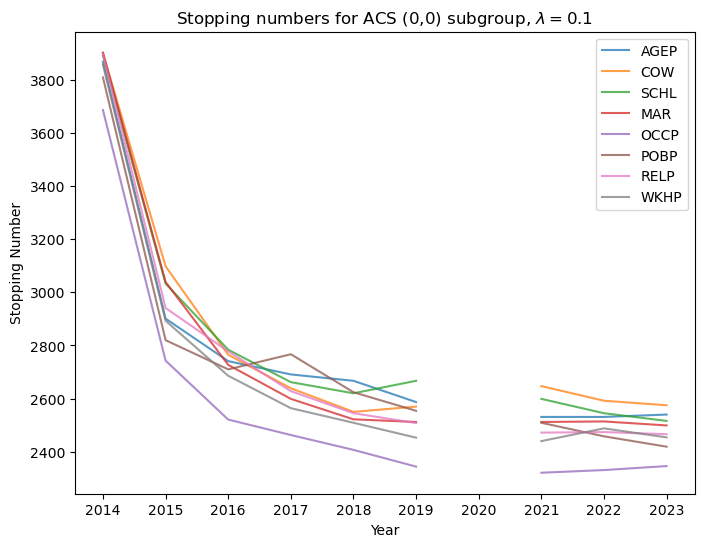

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

for feat in data_0_0.columns:
    stopping_nums = [int(sr.v) for sr in rules[feat].rules]
    stopping_nums.insert(np.where(target_years == 2020)[0][0], np.nan)

    ax.plot(target_years, stopping_nums, alpha=0.75, label=feat)

ax.set_ylabel('Stopping Number')
# ax.set_ylim(500, 2000)

ax.set_xlabel('Year')
ax.legend()
ax.set_title('Stopping numbers for ACS (0,0) subgroup, $\lambda = 0.1$')

ax.set_xticks(target_years)

In [42]:
l = 0.0
cold_rules = {}

for feat in data_0_0.columns:
    rsr = RecursiveStoppingRule(N_bar=N_bar, x_min=min(data_0_0[feat]), x_max=max(data_0_0[feat]), epsilon=1e-2, v_init=1e-4)
    cold_rules[feat] = rsr

for year in target_years:
    if year == 2020: continue

    print(f'\n{year} ----')
    ca_features, _ = load_preprocess_ACS(year)
    data_0_0 = ca_features[(ca_features['RAC1P']==0) & (ca_features['SEX']==0)]
    data_0_0 = data_0_0.drop(columns=['SEX', 'RAC1P'])

    for feat in data_0_0.columns:
        for x in ca_features[feat]:
            if cold_rules[feat].sample(x):
                # print(f'\tLearning complete for {feat} after {int(cold_rules[feat].curr_rule.v)} samples.')
                break

        cold_rules[feat].increment_t(l)


2014 ----

2015 ----

2016 ----

2017 ----

2018 ----

2019 ----

2021 ----

2022 ----

2023 ----


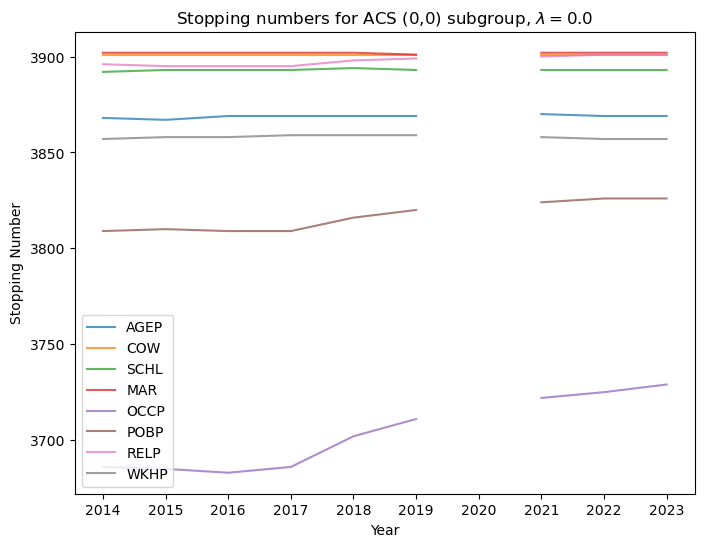

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

for feat in data_0_0.columns:
    stopping_nums = [int(sr.v) for sr in cold_rules[feat].rules]
    stopping_nums.insert(np.where(target_years == 2020)[0][0], np.nan)

    ax.plot(target_years, stopping_nums, alpha=0.75, label=feat)

ax.set_ylabel('Stopping Number')
# ax.set_ylim(500, 2000)

ax.set_xlabel('Year')
ax.legend()
ax.set_title('Stopping numbers for ACS (0,0) subgroup, $\lambda = 0.0$')

ax.set_xticks(target_years)